In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

# Importing metrics:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Importing pipeline:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.naive_bayes import MultinomialNB

# Regular Expression
import re
import string
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize

# For saving and loading machine learning model
import pickle

#Quality of image:
%config InlineBackend.figure_format = 'svg'

### Reading Data

In [2]:
dataDirectory = os.path.join(os.path.dirname(os.getcwd()),'test_case\\data')
modelDirectory = os.path.join(os.path.dirname(os.getcwd()),'test_case\\model')

In [3]:
df = pd.read_csv(dataDirectory + "\\df_source.csv")
df.head(2)

,Unnamed: 0,label,message
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...


### A function for applying model

In [4]:
def applyModel(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    # Evaluate the model:
    y_pred_test = model.predict(X_test)
    accuracy = accuracy_score(y_pred = y_pred_test, y_true=y_test)
    precision = precision_score(y_pred = y_pred_test, y_true=y_test)
    recall = recall_score(y_pred = y_pred_test, y_true=y_test)
    f1 = f1_score(y_pred = y_pred_test, y_true=y_test)
    
    print('Accuracy= {:0.2f} %'.format(100*accuracy))
    print('Precision= {:0.2f} %'.format(100 * precision))
    print('Recall= {:0.2f} %'.format(100*recall))
    print('f1= {:0.2f} %'.format(100*f1))

    return model

### Distribution of messages:

Text(0, 0.5, '')

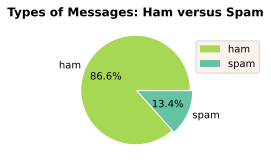

In [5]:
fig, ax = plt.subplots(figsize = (6,2.5))
lblComparison=pd.value_counts(df['label'], sort= True)
lblLst = lblComparison.index


# only exploding the 2nd slice 
explode = (0, 0.05)

patches, texts, auto  = ax.pie(lblComparison, labels =lblLst, explode=explode, autopct='%1.1f%%')
n = len(patches)
for i in range(n):
    x = (n-1)/n - i/n
    patches[i].set_facecolor(plt.cm.Set2(x))


ax.set_title('Types of Messages: Ham versus Spam', fontweight="bold")
ax.legend(loc="upper right", facecolor='linen', bbox_to_anchor=(1.45, 0.9))
ax.set_ylabel('')

### Some preparation

In [6]:
# Droping non necessary column: 
df.drop('Unnamed: 0', axis=1, inplace=True)

#Converting target feature into integer:
df['isSpam'] = (df['label']=='spam').astype(int)

# Changing order of columns:
df = df[['message', 'isSpam']]

df.head(2)

,message,isSpam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0


In [7]:
X = df['message']
y = df['isSpam']

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=34)

### Saving non-seen data for data streaming

In [8]:
df_test = X_test.to_frame()
df_test['isSpam'] = y_test

df_test.to_csv((os.path.join(dataDirectory,'df_test.csv')), index=False)

In [9]:
stopWordLst = stopwords.words('english')
stemmer = SnowballStemmer('english')

### Saprse matrix of bag of word
- since the bag of word matrix tends to be very sparse, it is helpful to apply some preprocessing to reduce this issue; it can includes: 
    - Transforming into lowercase,
    - Keeping only alphabetical chars,
    - Removing stop_words, 
    - Taking root of each word by applying stemer

In [10]:
def text_process(text):
    """
    input: raw text, 
    Applying preprocess and transformations including: 
    lowercase,
    keeping only alphabetical chars,
    removing stop_words, 
    taking root by stem of word
    """
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)
    tokenLst = word_tokenize(text)
    lst1 = [stemmer.stem(token) for token in tokenLst if token not in stopWordLst]
    text = ' '.join(lst1)
    return text

In [11]:
df['processed'] = df['message'].apply(text_process)

In [12]:
X = df['processed']
y = df['isSpam']

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=34)

### A handy heyperparamater tuning:

In [13]:
vectorizer = CountVectorizer(stop_words = 'english', ngram_range = (1, 2), token_pattern=r'\b\w+\b')

X_train_Final = vectorizer.fit_transform(X_train)
X_test_Final = vectorizer.transform(X_test)

# Tunning MultinomialNB with Bag Of Word Dataset
nbModel = MultinomialNB()
parameters = {'alpha':[0.0, 0.001, 0.01, 0.1, 0.5, 0.75, 0.85, 1, 3, 4, 10]}
clf = GridSearchCV(nbModel, parameters, cv = 5, scoring="accuracy")
clf.fit(X_train_Final, y_train)
clf.best_params_

C:\Users\tohid\AppData\Roaming\Python\Python38\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\tohid\AppData\Roaming\Python\Python38\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\tohid\AppData\Roaming\Python\Python38\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\tohid\AppData\Roaming\Python\Python38\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\tohid\AppData\Roaming\Python\Python

{'alpha': 4}

In [14]:
nbModel = MultinomialNB(alpha=4)
nbModel = applyModel(nbModel, X_train_Final, y_train, X_test_Final, y_test)

Accuracy= 98.30 %
Precision= 100.00 %
Recall= 87.16 %
f1= 93.14 %


### Note:
- According to the concept of spam classifier, the focus is supposed to be on the False-Positive rate. In other word, it is important to get high Precision score.
- The results show that the simple bag of word model is working well for us.
- And, it is assumed that the goal is not focusing on model optimizing, otherwise it is worthful to check TF-IDF vectorizer and also word-embedding approaches. The latter can provide us vectorized representative for each word which can improve other business metrics too.

### Pipeline over vectorizer and MultinomialNB model:

In [15]:
steps = [('vec', CountVectorizer(stop_words = 'english',
                                 ngram_range = (1, 2),
                                 token_pattern=r'\b\w+\b')), 
         ('nb', MultinomialNB(alpha=4))]

finalModel = Pipeline(steps)
finalModel.fit(X_train, y_train);

### Saving final model:

In [16]:
# Saving model to disk:
fileName = modelDirectory + "\\model.sav"
pickle.dump(finalModel, open(fileName, 'wb'))